# Libraries

In [26]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import dask.dataframe as dd

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

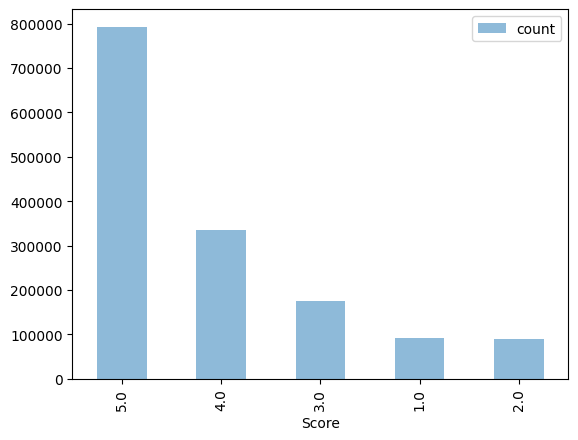


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [27]:
trainingSet = dd.read_csv("train.csv").compute()
testingSet = dd.read_csv("test.csv").compute()

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [28]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from textblob import TextBlob

def add_features_to(df, include_sentiment=True):
    # Handle missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
        df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(1)  # Avoid division by zero
        df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Handle missing values in the 'Text' column
    df['Text'] = df['Text'].fillna('')

    # Vectorized ReviewWordCount and ReviewCharCount
    df['ReviewWordCount'] = df['Text'].str.split().str.len()
    df['ReviewCharCount'] = df['Text'].str.len()

    # Optional Sentiment Analysis Features
    if include_sentiment:
        def get_sentiment(text):
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity

        df[['Polarity', 'Subjectivity']] = df['Text'].apply(lambda x: pd.Series(get_sentiment(x)))

    # Additional Length and Uniqueness Features
    df['AvgWordLength'] = df['ReviewCharCount'] / (df['ReviewWordCount'] + 1e-5)  # Avoid div by zero
    df['UniqueWordCount'] = df['Text'].str.split().apply(set).str.len()
    df['UniqueWordRatio'] = df['UniqueWordCount'] / (df['ReviewWordCount'] + 1e-5)

    # Helpfulness Flag
    df['IsHelpful'] = (df['HelpfulnessRatio'] >= 0.5).astype(int)

    # Grouped Statistics for Product and Reviewer
    if 'ProductId' in df.columns and 'Score' in df.columns:
        product_stats = df.groupby('ProductId')['Score'].agg(
            ProductAvgRating='mean', ProductReviewCount='count'
        )
        df = df.merge(product_stats, on='ProductId', how='left')

    if 'UserId' in df.columns and 'Score' in df.columns:
        reviewer_stats = df.groupby('UserId')['Score'].agg(
            ReviewerAvgRating='mean', ReviewerReviewCount='count'
        )
        df = df.merge(reviewer_stats, on='UserId', how='left')

    # Add interaction terms
    df['HelpfulnessRatio_x_Polarity'] = df['HelpfulnessRatio'] * df['Polarity']
    df['HelpfulnessRatio_x_Subjectivity'] = df['HelpfulnessRatio'] * df['Subjectivity']
    df['Polarity_x_ReviewerReviewCount'] = df['Polarity'] * df['ReviewerReviewCount']

    # Normalize Numeric Metadata Features
    numeric_features = [
        'HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount', 'AvgWordLength', 
        'UniqueWordRatio', 'Polarity', 'Subjectivity', 'ProductAvgRating', 
        'ProductReviewCount', 'ReviewerAvgRating', 'ReviewerReviewCount',
        'HelpfulnessRatio_x_Polarity', 'HelpfulnessRatio_x_Subjectivity', 
        'Polarity_x_ReviewerReviewCount'
    ]
    
    # Check if numeric features exist before scaling
    available_features = [feat for feat in numeric_features if feat in df.columns]
    scaler = StandardScaler()
    df[available_features] = scaler.fit_transform(df[available_features].fillna(0))

    # Drop unused columns
    df = df.drop(['Time', 'Summary'], axis=1, errors='ignore')
    
    return df

In [29]:
# Load the feature extracted files if they've already been generated
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")

else:
    # Step 1: Apply feature engineering to the entire trainingSet
    full_train_with_features = add_features_to(trainingSet)

    # Step 2: Sample 20% from the engineered full_train_with_features to create X_train
    sampled_trainingSet = full_train_with_features.sample(frac=0.20, random_state=42)
    X_train = sampled_trainingSet  # This is used for model training

    # Step 3: Create X_submission by merging with testingSet on 'Id'
    X_submission = pd.merge(full_train_with_features, testingSet, left_on='Id', right_on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'], errors='ignore').rename(columns={'Score_y': 'Score'})

    # Step 4: Save processed X_train and X_submission for future use
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Data Processing-- Model Building

TF-IDF Vectorization

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def TFIDF_Vectorization(df):
    df['Text'] = df['Text'].fillna('')
    # Create TF-IDF vectorizer and fit it on the entire dataset
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, min_df=10, max_df=0.7)
    # Fit the vectorizer on the 'Text' column to capture the vocabulary and transform the text
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    print("TF-IDF vectorizer fitting completed!")
    return tfidf_matrix

def svd(matrix):
    # Apply Truncated SVD to reduce the dimensionality of the TF-IDF matrix
    n_components = 100  # You can adjust this number as needed
    svd = TruncatedSVD(n_components=n_components, random_state=42)  
    reduced = svd.fit_transform(matrix)
    print(f"Dimensionality reduced to {n_components} components using Truncated SVD.")
    return reduced

In [31]:
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_train)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_train.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_train = pd.concat([X_train.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_train with TF-IDF features is procssed")

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_train with TF-IDF features is procssed


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Define Metadata Features to Include
numeric_metadata_features = [
    'HelpfulnessRatio', 'ProductAvgRating', 'ProductReviewCount', 'ReviewerAvgRating', 'Polarity', 'Subjectivity',
    'HelpfulnessRatio_x_Polarity', 'HelpfulnessRatio_x_Subjectivity', 
    'Polarity_x_ReviewerReviewCount'  # Interaction terms already added
]

# Step 2: Select and Scale All Features
# Combine numeric metadata and TF-IDF features
numeric_metadata_df = X_train[numeric_metadata_features]  # Use existing features in X_train
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=[f"TFIDF_{i}" for i in range(tfidf_reduced.shape[1])])

# Concatenate metadata and TF-IDF reduced DataFrames
X_combined = pd.concat([numeric_metadata_df.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Apply StandardScaler to all features in X_combined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Convert the scaled array back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_combined.columns)

# Step 3: Define the Target Variable
y = X_train['Score'].fillna(X_train['Score'].median())  # Handle missing values in the target

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.25, random_state=42)

# Confirm Completion
print("Feature scaling, selection, and train-test split completed!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Feature scaling, selection, and train-test split completed!
X_train shape: (254630, 109)
X_test shape: (84877, 109)
y_train shape: (254630,)
y_test shape: (84877,)


In [41]:
# Impute NaN values with median for all numeric columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int']).columns

# Fill NaN values in X_train
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].median())

# Fill NaN values in X_test (or any test data)
X_test[numeric_columns] = X_test[numeric_columns].fillna(X_train[numeric_columns].median())  # Using training median

print("NaN values in numerical columns have been filled with median.")

NaN values in numerical columns have been filled with median.


# Model Creation

In [42]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict the scores on the test data
y_test_pred = xgb_model.predict(X_test)

print("XGBoost Model Training and Prediction Completed!")

XGBoost Model Training and Prediction Completed!


from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(xgb_model, param_distributions, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Step 1: Adjust the labels for Randomized Search to start from 0
y_train_adjusted = y_train - 1  # Adjust labels from [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4]

# Step 2: Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

# Step 3: Set up RandomizedSearchCV with adjusted labels
model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',  # Use your desired scoring metric here
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Step 4: Run RandomizedSearchCV with adjusted labels
random_search.fit(X_train, y_train_adjusted)

# Best parameters and score
print("Best Parameters from Randomized Search:", random_search.best_params_)
print("Best Score from Randomized Search:", random_search.best_score_)

# Step 5: Apply the best parameters to train the final model as described previously
best_params = random_search.best_params_
best_model = XGBClassifier(**best_params, random_state=42)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=  27.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=  27.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=  28.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2.0, subsample=1.0; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.5, reg_lambda=2.0, subsample=1.0; total time= 1.8min
[CV] END colsample_bytree=1.0, gamma=0.2, learning_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, reg_alpha=0.5, reg_lambda=1.0, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300, reg_alpha=0.1, reg_lambda=1.0, subsample=0.6; total time= 1.8min
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, reg

In [61]:
best_params = random_search.best_params_
print(best_params)

{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [78]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data in DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_adjusted)
dtest = xgb.DMatrix(X_test, label=y_test_adjusted)

# Set the parameters, including simplified parameters for reduced complexity
params = {
    'objective': 'multi:softmax',    # For classification with multiple classes
    'num_class': 5,                  # Number of classes in the target (0-4, representing 1-5)
    'max_depth': 3,                  # Shallower trees
    'min_child_weight': 5,           # More conservative splits
    'gamma': 0.1,                    # Penalty for creating new splits
    'subsample': 0.8,                # Fraction of samples for each tree
    'colsample_bytree': 0.8,         # Fraction of features for each tree
    'learning_rate': 0.05,           # Lower learning rate
    'n_estimators': 300,             # Number of boosting rounds
    'random_state': 42
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,           # Maximum boosting rounds
    early_stopping_rounds=10,      # Stop if no improvement after 10 rounds
    evals=evals,
    verbose_eval=True
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:47:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.56526	eval-mlogloss:1.56512
[1]	train-mlogloss:1.52688	eval-mlogloss:1.52655
[2]	train-mlogloss:1.48933	eval-mlogloss:1.48892
[3]	train-mlogloss:1.45543	eval-mlogloss:1.45489
[4]	train-mlogloss:1.42411	eval-mlogloss:1.42355
[5]	train-mlogloss:1.39541	eval-mlogloss:1.39476
[6]	train-mlogloss:1.36896	eval-mlogloss:1.36824
[7]	train-mlogloss:1.34447	eval-mlogloss:1.34370
[8]	train-mlogloss:1.32171	eval-mlogloss:1.32093
[9]	train-mlogloss:1.30133	eval-mlogloss:1.30048
[10]	train-mlogloss:1.28148	eval-mlogloss:1.28061
[11]	train-mlogloss:1.26345	eval-mlogloss:1.26255
[12]	train-mlogloss:1.24628	eval-mlogloss:1.24534
[13]	train-mlogloss:1.23084	eval-mlogloss:1.22988
[14]	train-mlogloss:1.21628	eval-mlogloss:1.21531
[15]	train-mlogloss:1.20229	eval-mlogloss:1.20126
[16]	train-mlogloss:1.18878	eval-mlogloss:1.18771
[17]	train-mlogloss:1.17607	eval-mlogloss:1.17502
[18]	train-mlogloss:1.16400	eval-mlogloss:1.16294
[19]	train-mlogloss:1.15246	eval-mlogloss:1.15135
[20]	train

In [90]:
# Make predictions on the test set
y_test_pred_adjusted = model.predict(dtest)

# Adjust predictions back to the original scale (1-5 range)
y_test_pred = y_test_pred_adjusted + 1

# Round the predictions to the nearest integer
y_test_pred = np.round(y_test_pred).astype(int)

# Adjust predictions by adding 1 if the labels are in the 0-4 range
y_test_pred = np.clip(y_test_pred, 1, 5)

# Model Evaluation

Accuracy on testing set =  0.6388774344050803


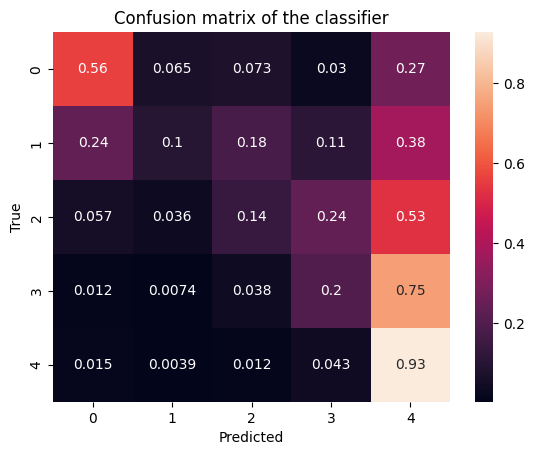

In [91]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(y_test, y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [71]:
# TF-IDF X_submission
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_submission)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_submission.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_submission_select = pd.concat([X_submission.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_submission with TF-IDF features:", X_submission.head())

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_submission with TF-IDF features:         Id   ProductId          UserId  \
0  1323432  B0034G4P30  A120UTHQDQIJGH   
1  1137299  B0012IWO0I  A3SJBFCTJWBFT2   
2  1459366  B005FUTBSC  A1V6FRU7EXP6N9   
3   931601  B000AREXBU   ARXDDR76Z5Q2I   
4  1311995  B002ZG99B8   A2XAS9GVZL3B1   

                                                Text  HelpfulnessRatio  \
0  This movie was just alright for me. I think pe...         -0.953032   
1  My kids love this movie.  Exciting and fun to ...          1.431414   
2  The effects were good, not the best but far fr...         -0.953032   
3  I just got a copy of this S. Korean dvd of "He...          1.431414   
4  OK, to put this clearly and bluntly... if you ...          1.431414   

   ReviewWordCount  ReviewCharCount  Polarity  Subjectivity  AvgWordLength  \
0        -0.012424        -0.071850  0.473931     -0.265934      -0.636208   
1        -0.

In [72]:
X_submission_select.columns

Index(['Id', 'ProductId', 'UserId', 'Text', 'HelpfulnessRatio',
       'ReviewWordCount', 'ReviewCharCount', 'Polarity', 'Subjectivity',
       'AvgWordLength',
       ...
       'TFIDF_90', 'TFIDF_91', 'TFIDF_92', 'TFIDF_93', 'TFIDF_94', 'TFIDF_95',
       'TFIDF_96', 'TFIDF_97', 'TFIDF_98', 'TFIDF_99'],
      dtype='object', length=121)

In [73]:
features = X_test.columns

X_submission_select = X_submission_select[features]

# Regular
# Create the submission file with discrete scores
X_submission['Score'] = model.predict(X_submission_select)

# Round the predictions to the nearest integer and clip them to the valid score range (e.g., 1 to 5)
X_submission['Score'] = X_submission['Score'].round().clip(1, 5).astype(int)

# Prepare the final submission DataFrame
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)
print("submission file created")

In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Ensure X_submission_select is in DMatrix format if using the native XGBoost API
X_submission_dmatrix = xgb.DMatrix(X_submission_select)

# Make predictions using the trained model
X_submission['Score'] = model.predict(X_submission_dmatrix)

# If model was trained on labels shifted by -1, adjust predictions by adding 1
X_submission['Score'] = X_submission['Score'] + 1

# Round the predictions to the nearest integer and clip them to the valid score range (1 to 5)
X_submission['Score'] = X_submission['Score'].round().clip(1, 5).astype(int)

# Prepare the final submission DataFrame
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)
print("Submission file created")

Submission file created
